### Imports

In [20]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
import matplotlib.pyplot as plt
import random
import os

In [21]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### Create Environment

In [22]:
class TradingEnv(gym.Env):
    """
    Long-only Trading Environment.
    
    Actions:
        0 = Hold (no change)
        1 = Buy (go long with all capital)
        2 = Sell (close long, go flat/cash)
    
    Observations:
        - Flattened window of normalized features (window_size * n_features)
        - Current position flag (0 or 1)
    
    Reward:
        - Percent change in portfolio value (PnL) over the step,
          minus transaction costs when position changes.
    """

    def __init__(
        self,
        df,
        feature_cols=None,
        window_size=50,
        transaction_cost=0.001,      # 0.1% per trade
        initial_balance=1.0,
        reward_scaling=1.0,
        deterministic=True
    ):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or [
    "log_return", "SMA_short", "SMA_long", "volatility",
    "open_close_ratio", "high_low_range", "volume_zscore"
]
        self.window_size = window_size
        self.transaction_cost = transaction_cost
        self.initial_balance = initial_balance
        self.reward_scaling = reward_scaling
        self.deterministic = deterministic

        # Episode boundaries
        self.start_index = self.window_size
        self.end_index = len(self.df) - 1  # we look at current_step+1, so stop one step early

        # Spaces
        self.action_space = spaces.Discrete(3)  # 0 hold, 1 buy, 2 sell
        self.n_features = len(self.feature_cols)
        obs_len = self.window_size * self.n_features + 1  # plus position flag
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        # Random or deterministic start
        if self.deterministic:
            self.current_step = self.start_index
        else:
            self.current_step = np.random.randint(self.start_index, self.end_index - 1)

        # Portfolio state
        self.position = 0  # 0 flat, 1 long
        self.cash = self.initial_balance
        self.invested = 0.0  # how much capital invested in asset
        self.entry_price = 0.0  # entry price of position
        self.portfolio_value = self.cash

        # Trade log (time, action, price, portfolio value)
        self.trades = []

        return self._get_obs(), {}

    def _get_obs(self):
        """Build observation vector: normalized window + position flag."""
        start = self.current_step - self.window_size + 1
        end = self.current_step + 1
        window = self.df.iloc[start:end][self.feature_cols].values  # shape (window_size, n_features)

        # Z-score normalization per window (no future leak)
        mean = window.mean(axis=0)
        std = window.std(axis=0) + 1e-9
        norm_window = (window - mean) / std

        obs = np.concatenate([
            norm_window.flatten(),
            np.array([self.position], dtype=np.float32)
        ])
        return obs.astype(np.float32)

    def step(self, action):
        """Execute one time step within the environment."""
        assert self.action_space.contains(action)
        done = False
        info = {}

        prev_portfolio_value = self.portfolio_value
        price_now = float(self.df["Close"].iloc[self.current_step])
        price_next = float(self.df["Close"].iloc[self.current_step + 1])

        prev_position = self.position

        # Action Handling
        if action == 1 and self.position == 0:  # Buy
            # invest all available cash into asset
            trade_notional = self.cash
            cost = self.transaction_cost * trade_notional
            self.invested = self.cash - cost
            self.entry_price = price_now
            self.position = 1
            self.cash = 0.0
            self.trades.append((self.current_step, 'BUY', price_now, self.portfolio_value))

        elif action == 2 and self.position == 1:  # Sell
            # Sell everything, go flat
            # First compute value of investment at current price
            current_value = self.invested * (price_now / self.entry_price)
            trade_notional = current_value
            cost = self.transaction_cost * trade_notional
            self.cash = current_value - cost
            self.invested = 0.0
            self.entry_price = 0.0
            self.position = 0
            self.trades.append((self.current_step, 'SELL', price_now, self.cash))

        # If holding long, update portfolio value based on next price
        if self.position == 1:
            # asset value changes with price ratio next/current
            asset_value_next = self.invested * (price_next / self.entry_price)
            self.portfolio_value = asset_value_next
        else:
            # flat -> portfolio value = cash
            self.portfolio_value = self.cash

        # Reward
        reward = (self.portfolio_value - prev_portfolio_value) / max(prev_portfolio_value, 1e-9)
        reward *= self.reward_scaling

        # Step forward
        self.current_step += 1
        if self.current_step >= self.end_index:
            done = True

        obs = self._get_obs()
        return obs, float(reward), done, False, info

    def render(self, mode="human"):
        """Print basic state info."""
        print(
            f"Step: {self.current_step}, Pos: {self.position}, "
            f"Cash: {self.cash:.4f}, Invested: {self.invested:.4f}, "
            f"Portfolio: {self.portfolio_value:.4f}"
        )

    def close(self):
        pass

In [23]:
# load processed dataset
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df = df.sort_index() # ensure sorted

train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

env = TradingEnv(train_df, deterministic=False)
test_env = TradingEnv(test_df)
# Wrap in DummyVecEnv for SB3
vec_env = DummyVecEnv([lambda: env])

### Train model

In [24]:
log_dir = "./tb_logs/"
tb_name = "ppo_trading"

model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    tensorboard_log=log_dir,
    learning_rate=3e-4,          
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
)

eval_callback = EvalCallback(
    test_env,
    best_model_save_path="./models/",
    log_path="./models/",
    eval_freq=10_000,
    deterministic=True,
    render=False
)

model.learn(
    total_timesteps=500_000,
    tb_log_name=tb_name,
    callback=[eval_callback]
)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 598         |
|    iterations           | 36          |
|    time_elapsed         | 123         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.061375067 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.39       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0522     |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0374     |
|    value_loss           | 0.000813    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.06e+03

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=80000, episode_reward=0.72 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.724      |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.06785166 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0927    |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.0468    |
|    value_loss           | 0.000573   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | 4.46     |
| time/              |          |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=1.02 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 1.02       |
| time/                   |            |
|    total_timesteps      | 90000      |
| train/                  |            |
|    approx_kl            | 0.07374903 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0418    |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0431    |
|    value_loss           | 0.000826   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1e+03  |
|    ep_rew_mean     | 4.75     |
| time/              |          |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=0.90 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.897      |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.07238982 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.317     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0116    |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.000644   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1e+03  |
|    ep_rew_mean     | 5        |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=0.64 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.638      |
| time/                   |            |
|    total_timesteps      | 110000     |
| train/                  |            |
|    approx_kl            | 0.08294968 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0774    |
|    n_updates            | 530        |
|    policy_gradient_loss | -0.0347    |
|    value_loss           | 0.000663   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12e+03 |
|    ep_rew_mean     | 5.31     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=0.59 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.587      |
| time/                   |            |
|    total_timesteps      | 120000     |
| train/                  |            |
|    approx_kl            | 0.07504798 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0682    |
|    n_updates            | 580        |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 0.000845   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12e+03 |
|    ep_rew_mean     | 5.82     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=130000, episode_reward=0.61 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.609      |
| time/                   |            |
|    total_timesteps      | 130000     |
| train/                  |            |
|    approx_kl            | 0.09521444 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0342    |
|    n_updates            | 630        |
|    policy_gradient_loss | -0.0413    |
|    value_loss           | 0.000426   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12e+03 |
|    ep_rew_mean     | 6.3      |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=140000, episode_reward=0.57 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.568      |
| time/                   |            |
|    total_timesteps      | 140000     |
| train/                  |            |
|    approx_kl            | 0.07340757 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.289     |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0393    |
|    n_updates            | 680        |
|    policy_gradient_loss | -0.0348    |
|    value_loss           | 0.000439   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11e+03 |
|    ep_rew_mean     | 6.62     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=150000, episode_reward=0.60 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.603      |
| time/                   |            |
|    total_timesteps      | 150000     |
| train/                  |            |
|    approx_kl            | 0.08822375 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0327    |
|    n_updates            | 730        |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000686   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1e+03  |
|    ep_rew_mean     | 6.85     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=160000, episode_reward=0.72 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.722      |
| time/                   |            |
|    total_timesteps      | 160000     |
| train/                  |            |
|    approx_kl            | 0.09511092 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0724    |
|    n_updates            | 780        |
|    policy_gradient_loss | -0.0472    |
|    value_loss           | 0.000988   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11e+03 |
|    ep_rew_mean     | 7.11     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=170000, episode_reward=0.63 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.632      |
| time/                   |            |
|    total_timesteps      | 170000     |
| train/                  |            |
|    approx_kl            | 0.11089803 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.244     |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0666    |
|    n_updates            | 830        |
|    policy_gradient_loss | -0.045     |
|    value_loss           | 0.000756   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12e+03 |
|    ep_rew_mean     | 7.28     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=0.71 +/- 0.00
Episode length: 514.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 514      |
|    mean_reward          | 0.71     |
| time/                   |          |
|    total_timesteps      | 180000   |
| train/                  |          |
|    approx_kl            | 0.15321  |
|    clip_fraction        | 0.189    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.229   |
|    explained_variance   | 0.974    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0458  |
|    n_updates            | 870      |
|    policy_gradient_loss | -0.04    |
|    value_loss           | 0.000503 |
--------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08e+03 |
|    ep_rew_mean     | 7.14     |
| time/              |          |
|    fps             | 655      |
|    i

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=190000, episode_reward=0.87 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.871      |
| time/                   |            |
|    total_timesteps      | 190000     |
| train/                  |            |
|    approx_kl            | 0.08951044 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0598    |
|    n_updates            | 920        |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000816   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15e+03 |
|    ep_rew_mean     | 7.66     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=0.88 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.88       |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.10239599 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0261    |
|    n_updates            | 970        |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 0.00109    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08e+03 |
|    ep_rew_mean     | 7.24     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=0.75 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.754       |
| time/                   |             |
|    total_timesteps      | 210000      |
| train/                  |             |
|    approx_kl            | 0.124659754 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0619     |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.0378     |
|    value_loss           | 0.000605    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.04e+03 |
|    ep_rew_mean     | 6.96     |
| time/             

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=220000, episode_reward=0.83 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.826       |
| time/                   |             |
|    total_timesteps      | 220000      |
| train/                  |             |
|    approx_kl            | 0.110747874 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0469     |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.0436     |
|    value_loss           | 0.000751    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.01e+03 |
|    ep_rew_mean     | 6.89     |
| time/             

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=230000, episode_reward=0.79 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.788      |
| time/                   |            |
|    total_timesteps      | 230000     |
| train/                  |            |
|    approx_kl            | 0.10074116 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0531    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0347    |
|    value_loss           | 0.000609   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03e+03 |
|    ep_rew_mean     | 7.06     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=240000, episode_reward=0.20 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.2        |
| time/                   |            |
|    total_timesteps      | 240000     |
| train/                  |            |
|    approx_kl            | 0.09207102 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0424    |
|    n_updates            | 1170       |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 0.000728   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03e+03 |
|    ep_rew_mean     | 7.13     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=250000, episode_reward=0.47 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.472       |
| time/                   |             |
|    total_timesteps      | 250000      |
| train/                  |             |
|    approx_kl            | 0.095485985 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00384     |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.0255     |
|    value_loss           | 0.000413    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.05e+03 |
|    ep_rew_mean     | 7.21     |
| time/             

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=0.30 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.303      |
| time/                   |            |
|    total_timesteps      | 260000     |
| train/                  |            |
|    approx_kl            | 0.16109392 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0401    |
|    n_updates            | 1260       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000588   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08e+03 |
|    ep_rew_mean     | 7.38     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=0.33 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.332      |
| time/                   |            |
|    total_timesteps      | 270000     |
| train/                  |            |
|    approx_kl            | 0.10261741 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0229    |
|    n_updates            | 1310       |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 0.000424   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.07e+03 |
|    ep_rew_mean     | 7.25     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=0.61 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.609      |
| time/                   |            |
|    total_timesteps      | 280000     |
| train/                  |            |
|    approx_kl            | 0.12248552 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0342    |
|    n_updates            | 1360       |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000505   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09e+03 |
|    ep_rew_mean     | 7.4      |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=0.55 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.551      |
| time/                   |            |
|    total_timesteps      | 290000     |
| train/                  |            |
|    approx_kl            | 0.10554466 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0529    |
|    n_updates            | 1410       |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000618   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15e+03 |
|    ep_rew_mean     | 7.75     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=0.71 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.709      |
| time/                   |            |
|    total_timesteps      | 300000     |
| train/                  |            |
|    approx_kl            | 0.10074671 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.181     |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.058     |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.000559   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1e+03  |
|    ep_rew_mean     | 7.45     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=310000, episode_reward=0.83 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.829      |
| time/                   |            |
|    total_timesteps      | 310000     |
| train/                  |            |
|    approx_kl            | 0.11889382 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0685    |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 0.00055    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15e+03 |
|    ep_rew_mean     | 7.81     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=320000, episode_reward=0.59 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.585      |
| time/                   |            |
|    total_timesteps      | 320000     |
| train/                  |            |
|    approx_kl            | 0.11276268 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0761    |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.0351    |
|    value_loss           | 0.000444   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2e+03  |
|    ep_rew_mean     | 8.2      |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=330000, episode_reward=0.90 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.902      |
| time/                   |            |
|    total_timesteps      | 330000     |
| train/                  |            |
|    approx_kl            | 0.09468967 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0464    |
|    n_updates            | 1610       |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 0.00059    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19e+03 |
|    ep_rew_mean     | 8.15     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=340000, episode_reward=1.00 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 1          |
| time/                   |            |
|    total_timesteps      | 340000     |
| train/                  |            |
|    approx_kl            | 0.10620504 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0204    |
|    n_updates            | 1660       |
|    policy_gradient_loss | -0.0225    |
|    value_loss           | 0.00033    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2e+03  |
|    ep_rew_mean     | 8.15     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=0.86 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.864       |
| time/                   |             |
|    total_timesteps      | 350000      |
| train/                  |             |
|    approx_kl            | 0.111444384 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0408     |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.000605    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.21e+03 |
|    ep_rew_mean     | 8.25     |
| time/             

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=1.23 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 1.23       |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.10590523 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.179     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0621    |
|    n_updates            | 1750       |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 0.000442   |
----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.21e+03 |
|    ep_rew_mean     | 8.21     |
| time/         

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=0.50 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.504      |
| time/                   |            |
|    total_timesteps      | 370000     |
| train/                  |            |
|    approx_kl            | 0.10558561 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.165     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0574    |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0318    |
|    value_loss           | 0.000394   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2e+03  |
|    ep_rew_mean     | 8.16     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=0.24 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.244      |
| time/                   |            |
|    total_timesteps      | 380000     |
| train/                  |            |
|    approx_kl            | 0.14528543 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0721    |
|    n_updates            | 1850       |
|    policy_gradient_loss | -0.0389    |
|    value_loss           | 0.000303   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19e+03 |
|    ep_rew_mean     | 8.08     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=390000, episode_reward=0.50 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.498      |
| time/                   |            |
|    total_timesteps      | 390000     |
| train/                  |            |
|    approx_kl            | 0.11064629 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.174     |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0359    |
|    n_updates            | 1900       |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 0.0005     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.13e+03 |
|    ep_rew_mean     | 7.74     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=400000, episode_reward=0.76 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.757      |
| time/                   |            |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.10998189 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.165     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0332    |
|    n_updates            | 1950       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000381   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.13e+03 |
|    ep_rew_mean     | 7.81     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=410000, episode_reward=0.68 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.683      |
| time/                   |            |
|    total_timesteps      | 410000     |
| train/                  |            |
|    approx_kl            | 0.12702256 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0385    |
|    n_updates            | 2000       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 0.000366   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09e+03 |
|    ep_rew_mean     | 7.58     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=420000, episode_reward=0.67 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.671      |
| time/                   |            |
|    total_timesteps      | 420000     |
| train/                  |            |
|    approx_kl            | 0.14023024 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.056     |
|    n_updates            | 2050       |
|    policy_gradient_loss | -0.0399    |
|    value_loss           | 0.00047    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08e+03 |
|    ep_rew_mean     | 7.58     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=430000, episode_reward=0.40 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.397      |
| time/                   |            |
|    total_timesteps      | 430000     |
| train/                  |            |
|    approx_kl            | 0.10531464 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.188     |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0505    |
|    n_updates            | 2090       |
|    policy_gradient_loss | -0.0326    |
|    value_loss           | 0.000539   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.07e+03 |
|    ep_rew_mean     | 7.52     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=440000, episode_reward=0.42 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.418      |
| time/                   |            |
|    total_timesteps      | 440000     |
| train/                  |            |
|    approx_kl            | 0.12605056 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0428    |
|    n_updates            | 2140       |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 0.000767   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03e+03 |
|    ep_rew_mean     | 7.24     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=450000, episode_reward=0.76 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.762      |
| time/                   |            |
|    total_timesteps      | 450000     |
| train/                  |            |
|    approx_kl            | 0.10158908 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.18      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.027     |
|    n_updates            | 2190       |
|    policy_gradient_loss | -0.0287    |
|    value_loss           | 0.000429   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03e+03 |
|    ep_rew_mean     | 7.26     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=460000, episode_reward=0.50 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.498       |
| time/                   |             |
|    total_timesteps      | 460000      |
| train/                  |             |
|    approx_kl            | 0.110158876 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0311     |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0349     |
|    value_loss           | 0.000597    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03e+03 |
|    ep_rew_mean     | 7.27     |
| time/             

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=470000, episode_reward=0.82 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.824      |
| time/                   |            |
|    total_timesteps      | 470000     |
| train/                  |            |
|    approx_kl            | 0.09315417 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0575    |
|    n_updates            | 2290       |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.000207   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 988      |
|    ep_rew_mean     | 7.01     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=480000, episode_reward=0.77 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.775       |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.101631746 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0227     |
|    n_updates            | 2340        |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000406    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 990      |
|    ep_rew_mean     | 7.03     |
| time/             

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=490000, episode_reward=0.72 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.717      |
| time/                   |            |
|    total_timesteps      | 490000     |
| train/                  |            |
|    approx_kl            | 0.12150912 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.173     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0103    |
|    n_updates            | 2390       |
|    policy_gradient_loss | -0.0248    |
|    value_loss           | 0.000461   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 976      |
|    ep_rew_mean     | 6.94     |
| time/              |          |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500000, episode_reward=0.42 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.424      |
| time/                   |            |
|    total_timesteps      | 500000     |
| train/                  |            |
|    approx_kl            | 0.13020071 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0514    |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0411    |
|    value_loss           | 0.000803   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 977      |
|    ep_rew_mean     | 6.97     |
| time/              |          |
|   

### Evaluate model

In [25]:
# Evaluate the trained model
obs, _ = test_env.reset()
done = False

portfolio_values = [test_env.portfolio_value]
actions_taken = []
rewards = []

while not done:
    # deterministic=True to avoid exploration noise during evaluation
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    
    portfolio_values.append(test_env.portfolio_value)
    actions_taken.append(action)
    rewards.append(reward)

portfolio_values = np.array(portfolio_values)
actions_taken = np.array(actions_taken)
rewards = np.array(rewards)

In [26]:
final_value = portfolio_values[-1]
initial_value = portfolio_values[0]
total_return = (final_value / initial_value - 1) * 100

print(f"Initial Portfolio Value: {initial_value:.2f}")
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Daily Reward: {np.mean(rewards):.6f}")
print(f"Win Rate (positive rewards): {np.mean(rewards > 0) * 100:.2f}%")

Initial Portfolio Value: 1.00
Final Portfolio Value: 1.84
Total Return: 84.29%
Average Daily Reward: 0.001347
Win Rate (positive rewards): 27.24%


### Plots

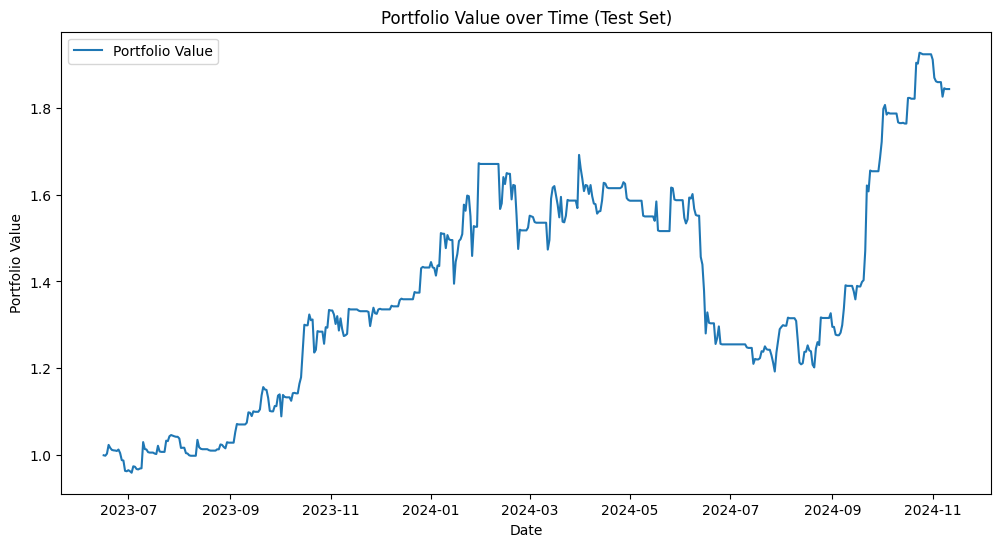

In [27]:
# Portfolio value over time

plt.figure(figsize=(12, 6))
plt.plot(test_df.index[:len(portfolio_values)], portfolio_values, label="Portfolio Value")
plt.title("Portfolio Value over Time (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

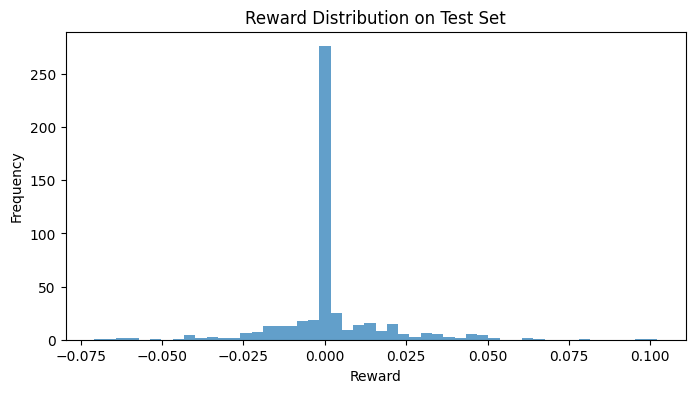

In [28]:
# reward distribution

plt.figure(figsize=(8, 4))
plt.hist(rewards, bins=50, alpha=0.7)
plt.title("Reward Distribution on Test Set")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()


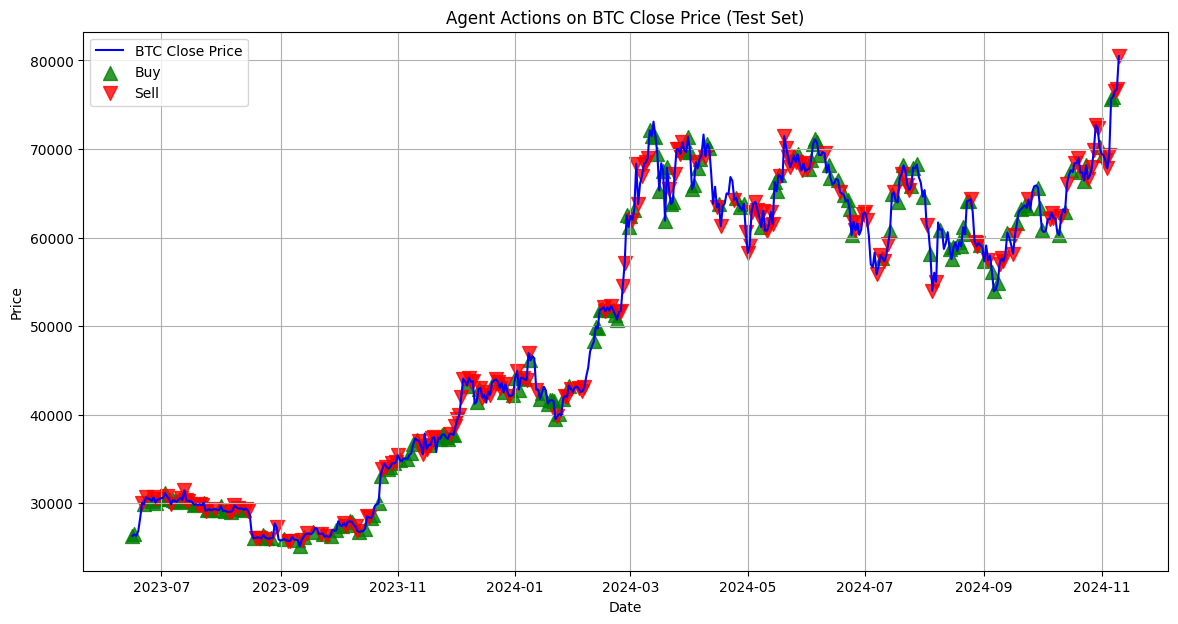

In [29]:
# Agent actions on BTC close price

# Extract closing prices for test period
prices = test_df["Close"].values[:len(actions_taken)]

# Identify buy and sell points
buy_points = np.where(actions_taken == 1)[0]
sell_points = np.where(actions_taken == 2)[0]

plt.figure(figsize=(14, 7))
plt.plot(test_df.index[:len(prices)], prices, label="BTC Close Price", color="blue")

# Plot buy markers
plt.scatter(
    test_df.index[buy_points],
    prices[buy_points],
    marker="^",
    color="green",
    label="Buy",
    alpha=0.8,
    s=100,
)

# Plot sell markers
plt.scatter(
    test_df.index[sell_points],
    prices[sell_points],
    marker="v",
    color="red",
    label="Sell",
    alpha=0.8,
    s=100,
)

plt.title("Agent Actions on BTC Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


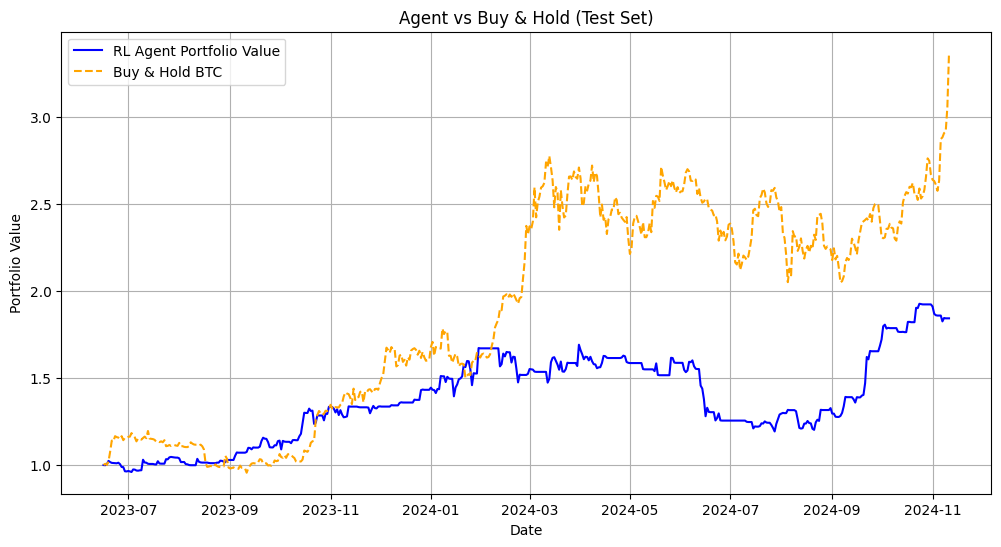

Agent Total Return: 84.29%
Buy & Hold Total Return: 236.92%


In [30]:
# Agent Equity Curve

agent_equity = portfolio_values

# Buy and Hold Equity Curve
initial_cash = agent_equity[0]
# Scale closing prices so that the first value equals initial cash
btc_prices = test_df["Close"].values[:len(agent_equity)]
buy_and_hold_equity = initial_cash * (btc_prices / btc_prices[0])

# Plot Both Curves
plt.figure(figsize=(12, 6))
plt.plot(test_df.index[:len(agent_equity)], agent_equity, label="RL Agent Portfolio Value", color="blue")
plt.plot(test_df.index[:len(agent_equity)], buy_and_hold_equity, label="Buy & Hold BTC", color="orange", linestyle="--")

plt.title("Agent vs Buy & Hold (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Compute Summary Metrics
agent_return = (agent_equity[-1] / agent_equity[0] - 1) * 100
bh_return = (buy_and_hold_equity[-1] / buy_and_hold_equity[0] - 1) * 100

print(f"Agent Total Return: {agent_return:.2f}%")
print(f"Buy & Hold Total Return: {bh_return:.2f}%")
